In [10]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline 

In [145]:
data_train = pd.read_csv("KDDTrain+.csv")
data = pd.read_csv("KDDTrain+.csv")

In [146]:
data.head()

,0,tcp,ftp_data,SF,491,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.18,2,2.1,0.00,0.00.1,0.00.2,0.00.3,1.00,0.00.4,0.00.5,150,25,0.17,0.03,0.17.1,0.00.6,0.00.7,0.00.8,0.05,0.00.9,normal,20
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [147]:
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome','level'])

In [148]:
data_train.columns = columns
data.columns = columns

In [153]:
features = ['duration','src_bytes','dst_bytes','num_file_creations', 
           'num_shells','num_failed_logins','wrong_fragment', 
           'urgent', 'is_guest_login', 'su_attempted', 'land', 'outcome']
df = data[features]

class_labels = ['normal', 'dos', 'probing', 'u2r', 'r2l']

# data has too many classes
# to simplify problem, categorize them generic network attack types : Probing, U2R, R2L, and DOS

dos = ['neptune', 'apache2', 'processtable', 'smurf', 'back', 'snmpguess', 'mailbomb', 'snmpgetattack',
              'pod', 'multihop', 'teardrop', 'sqlattack', 'land']
probing = ['mscan', 'satan', 'saint', 'portsweep', 'ipsweep', 'nmap', 'spy']
u2r = ['buffer_overflow', 'ps', 'xterm', 'perl', 'loadmodule', 'imap']
r2l = ['guess_passwd', 'warezmaster', 'httptunnel', 'named', 'sendmail', 'xlock','xsnoop', 'rootkit', 
       'ftp_write', 'worm', 'phf', 'udpstorm', 'warezclient']

# replace all values in dataframe with corresponding int value

df['outcome'].replace('normal', 0, inplace=True)
df['outcome'].replace(dos, 1, inplace=True)
df['outcome'].replace(probing, 2, inplace=True)
df['outcome'].replace(u2r, 3, inplace=True)
df['outcome'].replace(r2l, 4, inplace=True)

# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

features = df[['duration','src_bytes','dst_bytes','num_file_creations', 
           'num_shells','num_failed_logins','wrong_fragment', 
           'urgent', 'is_guest_login', 'su_attempted', 'land']]
labels = df['outcome']

X = np.array(features)
Y = np.array(labels).reshape(-1, 1)

# make sure both arrays have correct dimensions
print(X.shape)
print(Y.shape)


(125972, 11)
(125972, 1)


In [154]:
labels.unique()

array([1, 0, 2, 4, 3], dtype=int64)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   protocol_type                125972 non-null  object 
 2   service                      125972 non-null  object 
 3   flag                         125972 non-null  object 
 4   src_bytes                    125972 non-null  int64  
 5   dst_bytes                    125972 non-null  int64  
 6   land                         125972 non-null  int64  
 7   wrong_fragment               125972 non-null  int64  
 8   urgent                       125972 non-null  int64  
 9   hot                          125972 non-null  int64  
 10  num_failed_logins            125972 non-null  int64  
 11  logged_in                    125972 non-null  int64  
 12  num_compromised              125972 non-null  int64  
 13 

In [8]:
data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
count,125972.000000,1.259720e+05,1.259720e+05,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.0,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000
mean,287.146929,4.556710e+04,1.977927e+04,0.000198,0.022688,0.000111,0.204411,0.001222,0.395739,0.279253,0.001342,0.001103,0.302194,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.108207,27.738093,0.284487,0.282488,0.119959,0.121184,0.660925,0.063053,0.097322,182.149200,115.653725,0.521244,0.082952,0.148379,0.032543,0.284455,0.278487,0.118832,0.120241,19.504056
std,2604.525522,5.870354e+06,4.021285e+06,0.014086,0.253531,0.014366,2.149977,0.045239,0.489011,23.942137,0.036603,0.045155,24.399715,0.483937,0.022181,0.099370,0.0,0.002817,0.096613,114.508828,72.636092,0.446457,0.447024,0.320437,0.323648,0.439624,0.180315,0.259831,99.206565,110.702886,0.448950,0.188922,0.308998,0.112564,0.444785,0.445670,0.306559,0.319460,2.291512
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [13]:
data_train.loc[data_train['outcome'] == "normal", 'outcome'] = 'normal'
data_train.loc[data_train['outcome'] != "normal", 'outcome'] = 'attack'

In [10]:
# data['outcome'] = data['outcome'].replace(['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop'], 'DoS')
# data['outcome'] = data['outcome'].replace(['buffer_overflow', 'loadmodule', 'perl', 'rootkit'], 'U2R')
# data['outcome'] = data['outcome'].replace(['ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy', 'warezclient', 'warezmaster'], 'R2L')
# data['outcome'] = data['outcome'].replace(['ipsweep', 'nmap', 'portsweep', 'satan'], 'Probe')

In [11]:
data.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,attack,19
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,attack,21


In [12]:
def pie_plot(df, cols_list, rows, cols):
    fig, axes = plt.subplots(rows,cols)
    for ax, col in zip(axes.ravel(), cols_list):
        df[col].value_counts().plot(kind='pie', figsize=(15, 15), fontsize=10, autopct='%1.0f%%', ax=ax)
        ax.set_title(str(col), fontsize=12)
    plt.show()

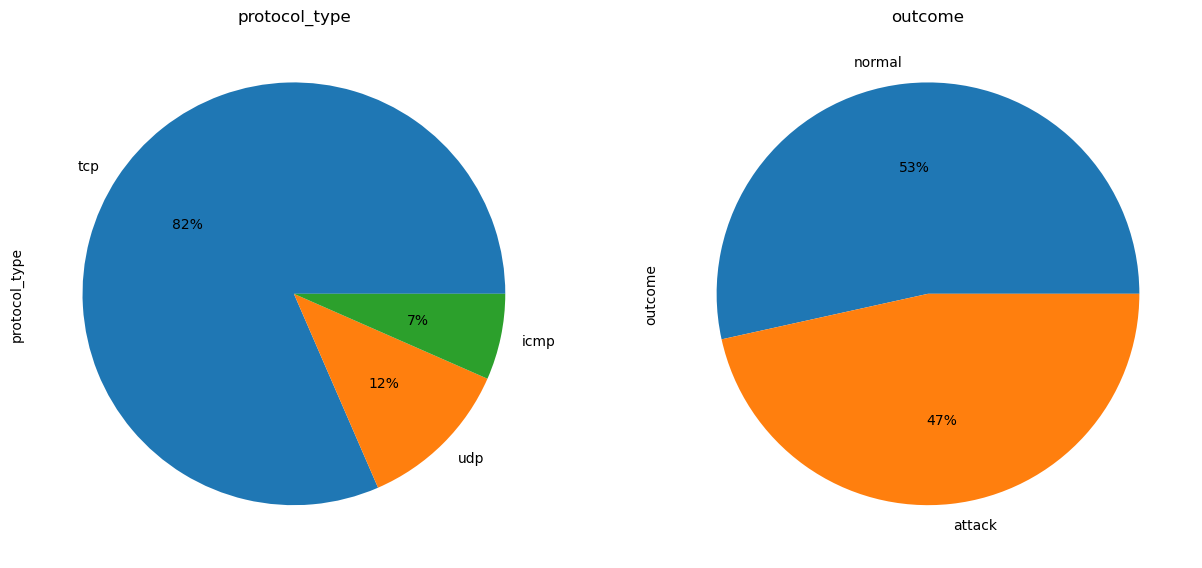

In [13]:
pie_plot(data_train, ['protocol_type', 'outcome'], 1, 2)

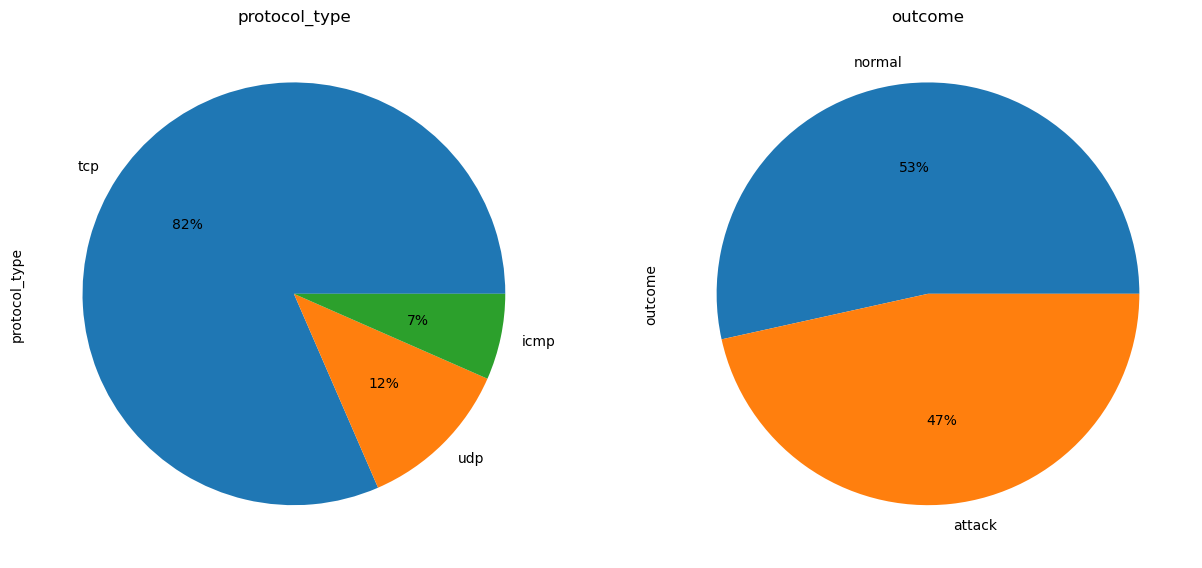

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,attack,19
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,attack,21


In [14]:
pie_plot(data, ['protocol_type', 'outcome'], 1, 2)
data.head()

In [14]:
def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns =cols)
    return std_df

In [15]:
cat_cols = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'level', 'outcome']
def preprocess(dataframe):
    df_num = dataframe.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    scaled_df = Scaling(df_num, num_cols)
    
    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]
    
    dataframe.loc[dataframe['outcome'] == "normal", "outcome"] = 0
    dataframe.loc[dataframe['outcome'] != 0, "outcome"] = 1
    
    dataframe = pd.get_dummies(dataframe, columns = ['protocol_type', 'service', 'flag'])
    return dataframe

In [16]:
scaled_train = preprocess(data_train)

In [18]:
data_train.head(10)

,protocol_type,service,flag,land,logged_in,is_host_login,is_guest_login,outcome,level,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,udp,other,SF,0,0,0,0,0,15,0.0,0.369565,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.007092,-0.4375,0.0,0.0,0.0,0.0,-1.010989,2.500000,0.00,0.000000,-0.253061,-0.536842,8.285714,14.666667,0.0,0.00,0.00,0.0,0.00
1,tcp,private,S0,0,0,0,0,1,19,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.773050,-0.1250,1.0,1.0,0.0,0.0,-1.043956,1.166667,0.00,0.000000,-0.151020,-0.431579,0.428571,0.000000,0.0,1.00,1.00,0.0,0.00
2,tcp,http,SF,0,1,0,0,0,21,0.0,0.681159,15.800388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.063830,-0.1875,0.2,0.2,0.0,0.0,0.000000,0.000000,0.00,-1.300578,0.783673,0.515789,-0.285714,0.500000,2.0,0.03,0.01,0.0,0.01
3,tcp,http,SF,0,1,0,0,0,21,0.0,0.561594,0.813953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113475,1.5000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.09,0.000000,0.783673,0.515789,-0.285714,0.000000,0.0,0.00,0.00,0.0,0.00
4,tcp,private,REJ,0,0,0,0,1,21,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.758865,0.6875,0.0,0.0,1.0,1.0,-0.923077,1.000000,0.00,0.000000,-0.179592,-0.463158,0.714286,0.000000,0.0,0.00,0.00,1.0,1.00
5,tcp,private,S0,0,0,0,0,1,21,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.078014,0.0625,1.0,1.0,0.0,0.0,-1.043956,1.000000,0.00,0.000000,-0.220408,-0.494737,0.428571,0.000000,0.0,1.00,1.00,0.0,0.00
6,tcp,private,S0,0,0,0,0,1,21,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.730496,0.5000,1.0,1.0,0.0,0.0,-0.945055,1.000000,0.00,0.000000,-0.195918,-0.473684,0.714286,0.000000,0.0,1.00,1.00,0.0,0.00
7,tcp,remote_job,S0,0,0,0,0,1,21,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.815603,0.9375,1.0,1.0,0.0,0.0,-1.000000,0.833333,0.00,0.000000,-0.163265,-0.442105,0.428571,0.000000,0.0,1.00,1.00,0.0,0.00
8,tcp,private,S0,0,0,0,0,1,21,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.843972,0.0000,1.0,1.0,0.0,0.0,-1.032967,1.000000,0.00,0.000000,-0.204082,-0.484211,0.571429,0.000000,0.0,1.00,1.00,0.0,0.00
9,tcp,private,REJ,0,0,0,0,1,21,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.354610,0.2500,0.0,0.0,1.0,1.0,-1.032967,1.000000,0.00,0.000000,-0.208163,-0.484211,0.714286,0.000000,0.0,0.00,0.00,1.0,1.00


In [155]:
x = scaled_train.drop(['outcome', 'level'] , axis = 1).values
y = scaled_train['outcome'].values

pca = PCA(n_components=20)
pca = pca.fit(x)
x_reduced = pca.transform(x)
print("Number of original features is {} and of reduced features is {}".format(x.shape[1], x_reduced.shape[1]))

y = y.astype('int')
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced = train_test_split(x_reduced, y, test_size=0.2, random_state=42)
x_train_multiclass, x_test_multiclass, y_train_multiclass, y_test_multiclass = train_test_split(X, Y, test_size=0.2, random_state=42)

Number of original features is 122 and of reduced features is 20


In [18]:
kernal_evals = dict()
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))
    
    train_precision = metrics.precision_score(y_train, model.predict(X_train))
    test_precision = metrics.precision_score(y_test, model.predict(X_test))
    
    train_recall = metrics.recall_score(y_train, model.predict(X_train))
    test_recall = metrics.recall_score(y_test, model.predict(X_test))
    
    kernal_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall]
    print("Training Accuracy " + str(name) + " {}  Test Accuracy ".format(train_accuracy*100) + str(name) + " {}".format(test_accuracy*100))
    print("Training Precesion " + str(name) + " {}  Test Precesion ".format(train_precision*100) + str(name) + " {}".format(test_precision*100))
    print("Training Recall " + str(name) + " {}  Test Recall ".format(train_recall*100) + str(name) + " {}".format(test_recall*100))
    
    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'attack'])

    fig, ax = plt.subplots(figsize=(10,10))
    ax.grid(False)
    cm_display.plot(ax=ax)

Training Accuracy KNeighborsClassifier 98.99381803387678  Test Accuracy KNeighborsClassifier 98.93629688430245
Training Precesion KNeighborsClassifier 99.20510451801405  Test Precesion KNeighborsClassifier 99.0813983158969
Training Recall KNeighborsClassifier 98.62454881356656  Test Recall KNeighborsClassifier 98.64510119400457


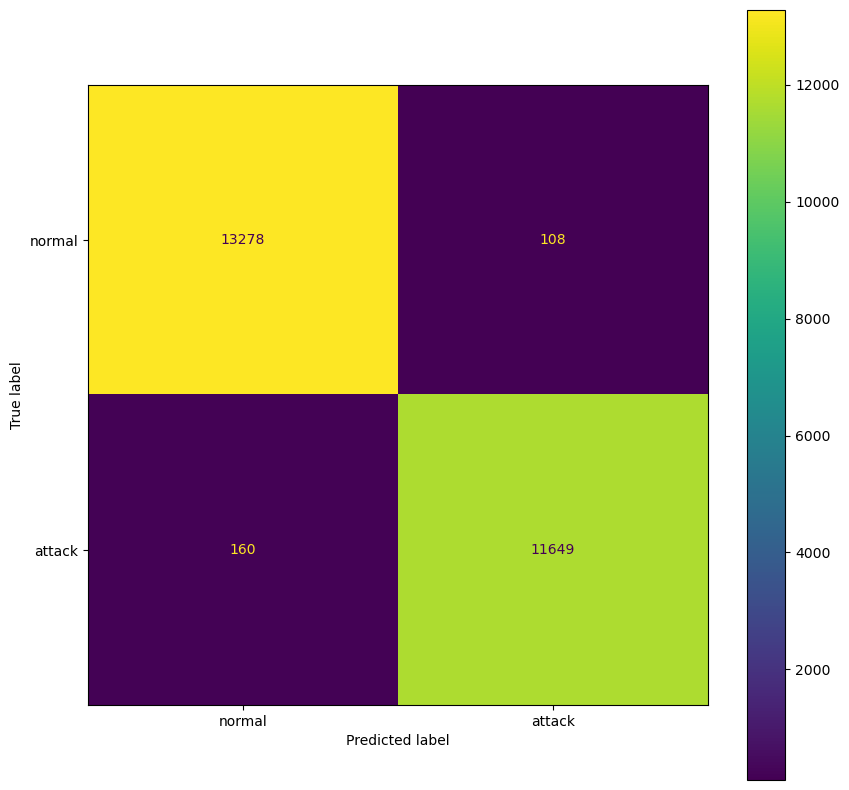

In [19]:
knn = KNeighborsClassifier(n_neighbors=20).fit(x_train_reduced, y_train_reduced)
evaluate_classification(knn, "KNeighborsClassifier", x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced)

Training Accuracy GaussianNB 77.03245780287169  Test Accuracy GaussianNB 76.78507640404843
Training Precesion GaussianNB 91.27872511071591  Test Precesion GaussianNB 90.86670323642348
Training Recall GaussianNB 55.906537664723096  Test Recall GaussianNB 56.10974680328563


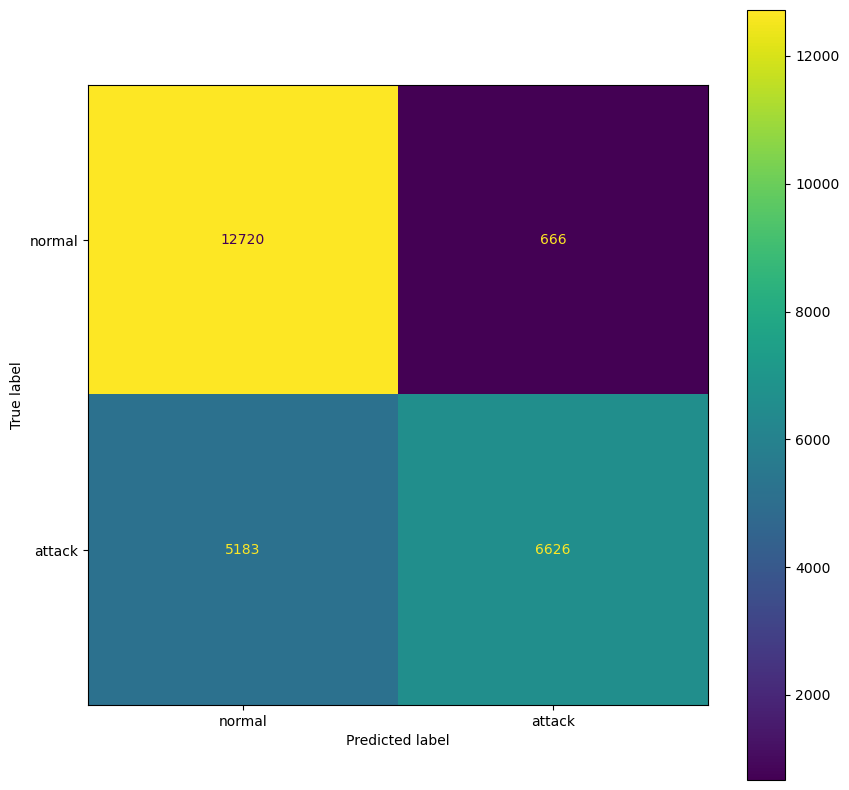

In [20]:
gnb = GaussianNB().fit(x_train_reduced, y_train_reduced)
evaluate_classification(gnb, "GaussianNB", x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced)

Training Accuracy DecisionTreeClassifier 98.71002312035483  Test Accuracy DecisionTreeClassifier 98.60686644175432
Training Precesion DecisionTreeClassifier 98.77842309423286  Test Precesion DecisionTreeClassifier 98.66632687733605
Training Recall DecisionTreeClassifier 98.44087054953974  Test Recall DecisionTreeClassifier 98.35718519773054


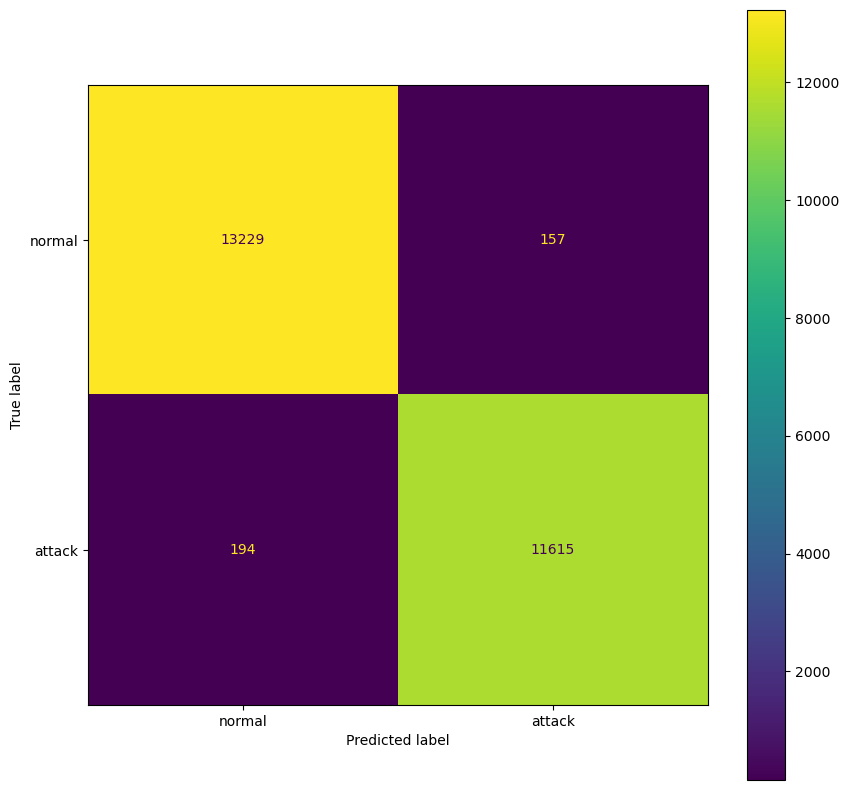

In [33]:
dt = DecisionTreeClassifier(max_depth=5).fit(x_train_reduced, y_train_reduced)
evaluate_classification(dt, "DecisionTreeClassifier", x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced)

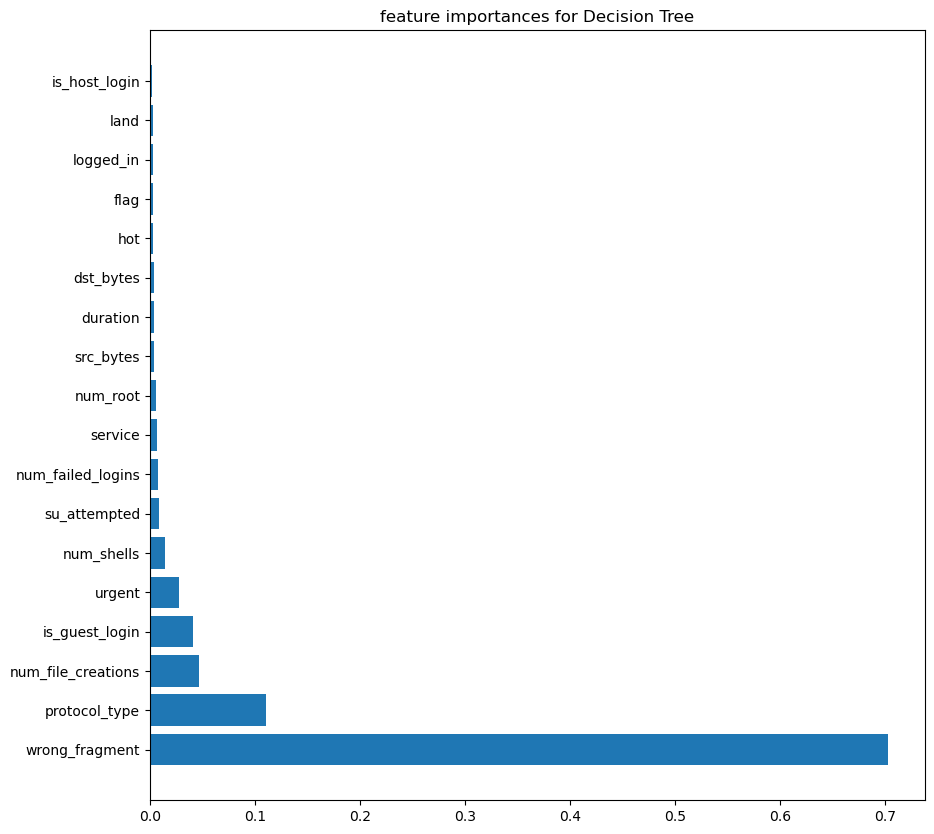

In [24]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)
    
    plt.figure(figsize=(10,10))
    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importances for Decision Tree')
    plt.show()

features_names = data_train.drop(['outcome', 'level'] , axis = 1)
f_importances(abs(tdt.feature_importances_), features_names, top=18)

[Text(0.5, 0.875, 'x[10] <= -0.081\ngini = 0.497\nsamples = 100777\nvalue = [53956, 46821]'),
 Text(0.25, 0.625, 'x[0] <= -167.519\ngini = 0.178\nsamples = 57045\nvalue = [51415, 5630]'),
 Text(0.125, 0.375, 'x[6] <= -3.476\ngini = 0.49\nsamples = 7377\nvalue = [3162, 4215]'),
 Text(0.0625, 0.125, 'gini = 0.096\nsamples = 3585\nvalue = [182, 3403]'),
 Text(0.1875, 0.125, 'gini = 0.337\nsamples = 3792\nvalue = [2980, 812]'),
 Text(0.375, 0.375, 'x[11] <= 0.341\ngini = 0.055\nsamples = 49668\nvalue = [48253, 1415]'),
 Text(0.3125, 0.125, 'gini = 0.027\nsamples = 48701\nvalue = [48043, 658]'),
 Text(0.4375, 0.125, 'gini = 0.34\nsamples = 967\nvalue = [210, 757]'),
 Text(0.75, 0.625, 'x[0] <= -167.517\ngini = 0.109\nsamples = 43732\nvalue = [2541, 41191]'),
 Text(0.625, 0.375, 'x[16] <= 0.995\ngini = 0.029\nsamples = 38240\nvalue = [566, 37674]'),
 Text(0.5625, 0.125, 'gini = 0.019\nsamples = 37990\nvalue = [363, 37627]'),
 Text(0.6875, 0.125, 'gini = 0.305\nsamples = 250\nvalue = [203, 47

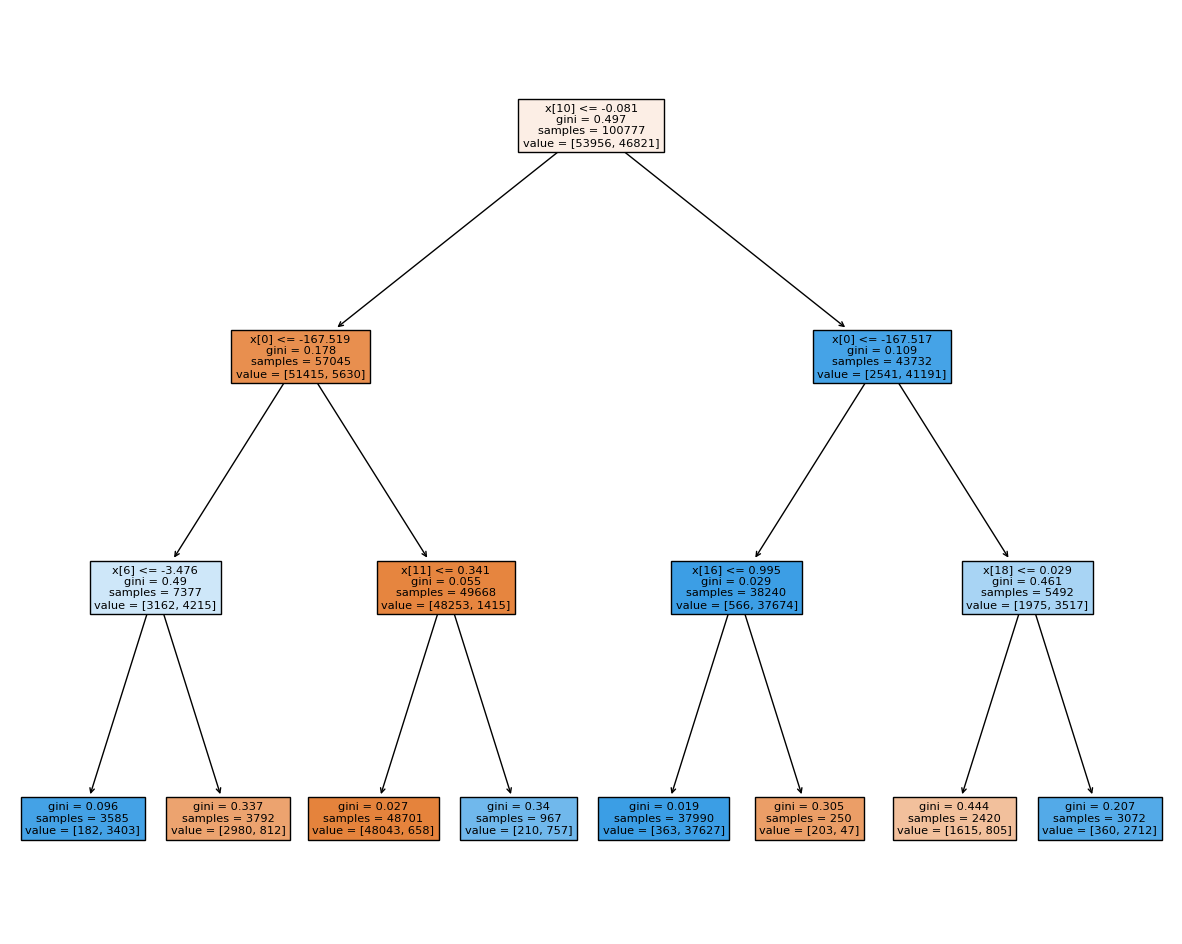

In [25]:
fig = plt.figure(figsize=(15,12))
tree.plot_tree(dt , filled=True)

Training Accuracy RandomForestClassifier 99.0057255127658  Test Accuracy RandomForestClassifier 98.90057551101408
Training Precesion RandomForestClassifier 99.31546658056183  Test Precesion RandomForestClassifier 99.3157714676702
Training Recall RandomForestClassifier 98.5391170628564  Test Recall RandomForestClassifier 98.33178084511813


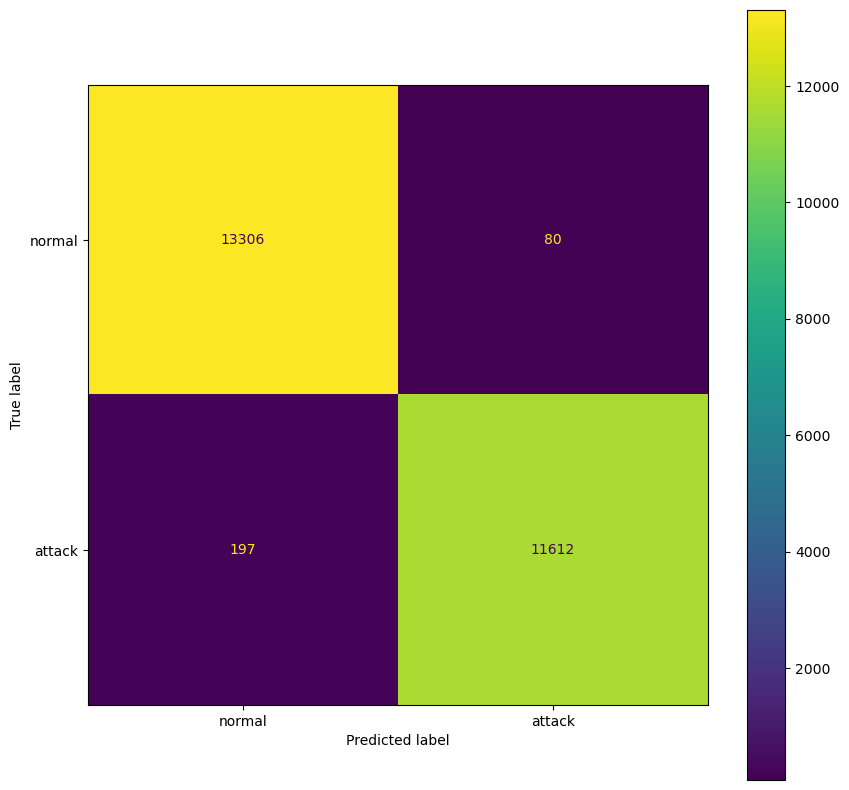

In [34]:
rf = RandomForestClassifier(max_depth=5, n_estimators=50).fit(x_train_reduced, y_train_reduced)
evaluate_classification(rf, "RandomForestClassifier", x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced)

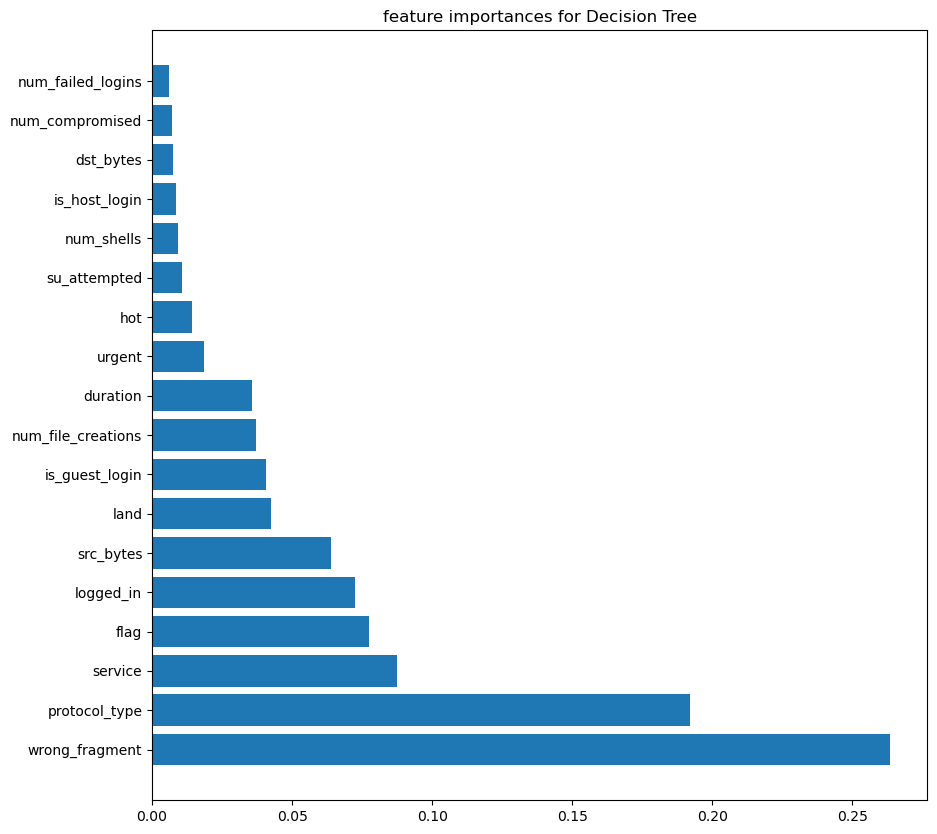

In [186]:
f_importances(abs(rf.feature_importances_), features_names, top=18)

In [37]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(x_train_reduced.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

In [38]:
model1.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [39]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                1344      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               66048     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [38]:
from keras.utils.vis_utils import plot_model
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [40]:
history = model1.fit(x_train_reduced, y_train_reduced, validation_data=(x_test_reduced, y_test_reduced), epochs=10, verbose=1)

Epoch 1/10
3150/3150 [==============================] - 12s 3ms/step - loss: 604.9033 - accuracy: 0.6586 - val_loss: 450.7094 - val_accuracy: 0.9408
Epoch 2/10
3150/3150 [==============================] - 10s 3ms/step - loss: 226.5530 - accuracy: 0.9264 - val_loss: 76.3063 - val_accuracy: 0.9575
Epoch 3/10
3150/3150 [==============================] - 10s 3ms/step - loss: 77.8821 - accuracy: 0.9475 - val_loss: 12.2605 - val_accuracy: 0.9616
Epoch 4/10
3150/3150 [==============================] - 10s 3ms/step - loss: 37.0419 - accuracy: 0.9543 - val_loss: 4.6273 - val_accuracy: 0.9617
Epoch 5/10
3150/3150 [==============================] - 10s 3ms/step - loss: 11.6334 - accuracy: 0.9566 - val_loss: 10.2923 - val_accuracy: 0.9674
Epoch 6/10
3150/3150 [==============================] - 10s 3ms/step - loss: 7.4962 - accuracy: 0.9599 - val_loss: 7.2524 - val_accuracy: 0.9720
Epoch 7/10
3150/3150 [==============================] - 10s 3ms/step - loss: 2.4079 - accuracy: 0.9587 - val_loss: 11.

In [42]:
test_loss, test_accuracy = model1.evaluate(x_test_reduced, y_test_reduced)

# Print the accuracy
print("Test accuracy:", test_accuracy)

788/788 [==============================] - 1s 1ms/step - loss: 3.1792 - accuracy: 0.9694
Test accuracy: 0.9693589806556702


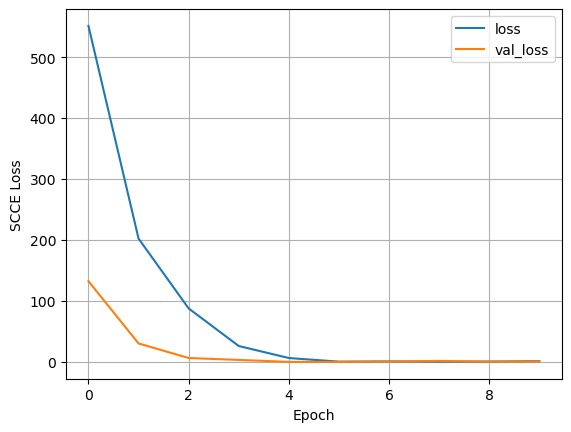

In [43]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('SCCE Loss')
plt.legend()
plt.grid(True)

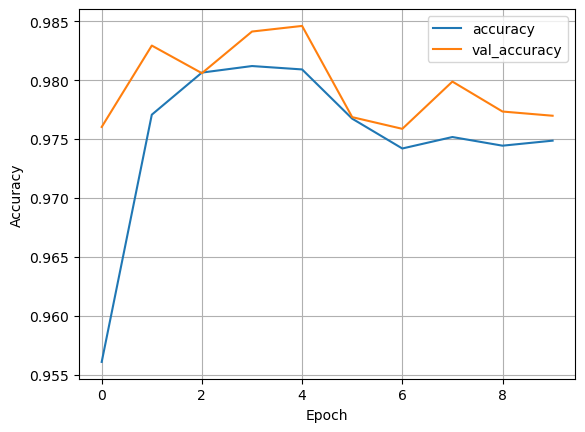

In [44]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [55]:
import pickle

pickle.dump(model, open('E:\jupyter\Models\cnn_model_edi.pkl', 'wb'))
pickle.dump(model1, open('E:\jupyter\Models\mlp_model_edi.pkl', 'wb'))

In [58]:
pickle.dump(lr, open('E:\jupyter\Models\lr_model_edi.pkl', 'wb'))
pickle.dump(knn, open('E:\jupyter\Models\knn_model_edi.pkl', 'wb'))
pickle.dump(gnb, open('E:\jupyter\Models\gnb_model_edi.pkl', 'wb'))
pickle.dump(lin_svc, open('E:\jupyter\Models\lin_svc_model_edi.pkl', 'wb'))
pickle.dump(dt, open('E:\jupyter\Models\dt_model_edi.pkl', 'wb'))
pickle.dump(rf, open('E:\\jupyter\\Models\\rf_model_edi.pkl', 'wb'))
pickle.dump(xg_r, open('E:\\jupyter\\Models\\xgb_model_edi.pkl', 'wb'))


In [189]:
model = Sequential()

model.add(Dense(units=32, activation='relu', input_dim=(11)))

model.add(Dense(units=24, activation='relu'))
model.add(Dropout(.2))

model.add(Dense(units=11, activation='relu'))
model.add(Dropout(.2))

model.add(Dense(units=8, activation='relu'))

model.add(Dense(units=5, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [213]:
model.fit(x_train_multiclass, y_train_multiclass, epochs=20, batch_size=32, class_weight=class_weights)

Epoch 1/20
3150/3150 [==============================] - 6s 2ms/step - loss: 13013.5410 - accuracy: 0.5428
Epoch 2/20
3150/3150 [==============================] - 5s 2ms/step - loss: 86.7067 - accuracy: 0.7634
Epoch 3/20
3150/3150 [==============================] - 5s 2ms/step - loss: 125.5105 - accuracy: 0.7771
Epoch 4/20
3150/3150 [==============================] - 5s 2ms/step - loss: 74.1114 - accuracy: 0.8253
Epoch 5/20
3150/3150 [==============================] - 5s 2ms/step - loss: 57.0382 - accuracy: 0.8508
Epoch 6/20
3150/3150 [==============================] - 5s 2ms/step - loss: 61.0411 - accuracy: 0.8662
Epoch 7/20
3150/3150 [==============================] - 5s 2ms/step - loss: 42.1652 - accuracy: 0.8786
Epoch 8/20
3150/3150 [==============================] - 5s 2ms/step - loss: 26.3960 - accuracy: 0.8831
Epoch 9/20
3150/3150 [==============================] - 5s 2ms/step - loss: 25.5679 - accuracy: 0.8836
Epoch 10/20
3150/3150 [==============================] - 5s 2ms/step 

In [210]:
model_without_weights = Sequential()

model_without_weights.add(Dense(units=32, activation='relu', input_dim=(11)))

model_without_weights.add(Dense(units=24, activation='relu'))
model_without_weights.add(Dropout(.2))

model_without_weights.add(Dense(units=24, activation='relu'))
model_without_weights.add(Dropout(.2))

model_without_weights.add(Dense(units=11, activation='relu'))
model_without_weights.add(Dropout(.2))

model_without_weights.add(Dense(units=8, activation='relu'))

model_without_weights.add(Dense(units=5, activation='softmax'))

model_without_weights.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [212]:
model_without_weights.fit(x_train_multiclass, y_train_multiclass, epochs=20, batch_size=32)

Epoch 1/20
788/788 [==============================] - 2s 2ms/step - loss: 0.6200 - accuracy: 0.8208
Epoch 2/20
788/788 [==============================] - 2s 2ms/step - loss: 0.5885 - accuracy: 0.8245
Epoch 3/20
788/788 [==============================] - 2s 2ms/step - loss: 0.5677 - accuracy: 0.8278
Epoch 4/20
788/788 [==============================] - 2s 2ms/step - loss: 0.5438 - accuracy: 0.8453
Epoch 5/20
788/788 [==============================] - 2s 2ms/step - loss: 0.5275 - accuracy: 0.8549
Epoch 6/20
788/788 [==============================] - 2s 2ms/step - loss: 0.5269 - accuracy: 0.8615
Epoch 7/20
788/788 [==============================] - 2s 2ms/step - loss: 0.5029 - accuracy: 0.8641
Epoch 8/20
788/788 [==============================] - 2s 2ms/step - loss: 0.4993 - accuracy: 0.8642
Epoch 9/20
788/788 [==============================] - 2s 2ms/step - loss: 0.4919 - accuracy: 0.8668
Epoch 10/20
788/788 [==============================] - 2s 2ms/step - loss: 0.4903 - accuracy: 0.8690

In [207]:
test_loss_mc, test_accuracy_mc = model_without_weights.evaluate(x_test_multiclass, y_test_multiclass)

# Print the accuracy
print("Test accuracy:", test_accuracy_mc)


788/788 [==============================] - 1s 1ms/step - loss: 0.4396 - accuracy: 0.8832
Test accuracy: 0.8831911087036133


In [132]:
import random
prediction_index = random.randint(0, len(x_test_multiclass))

# make prediction
# pred_input = np.array(list(x_test_multiclass.iloc[prediction_index])).reshape(1, 11)
pred_input = x_test_multiclass[prediction_index].reshape(1, 11)
prediction = class_labels[model.predict( pred_input ).argmax()]
actual = class_labels[int(y_test_multiclass[prediction_index])]



# compare prediction vs actual value
print(f'Predicted Value: {prediction}')
print(f'Actual Value: {actual}')
print(prediction_index)

1/1 [==============================] - 0s 16ms/step
Predicted Value: normal
Actual Value: normal
12388


In [156]:
unique_values, counts = np.unique(Y, return_counts=True)

# Print unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")


0: 67342
1: 45934
2: 11658
3: 53
4: 985


In [160]:
#class_labels = ['normal', 'dos', 'probing', 'u2r', 'r2l']
counts
total=0
for i in range(0,len(counts)):
    total = total +counts[i]
    
total

125972

In [179]:
weight_for_normal = (1 / counts[0]) * (total / 2.0)
weight_for_dos = (1 / counts[1]) * (total / 2.0)
weight_for_probing = (1 / counts[2]) * (total / 2.0)
weight_for_u2r = (1 / counts[3]) * (total / 2.0)
weight_for_r2l = (1 / counts[4]) * (total / 2.0)
print(weight_for_r2l, weight_for_dos, weight_for_normal, weight_for_probing, weight_for_u2r)

63.94517766497462 1.3712282840597378 0.9353152564521399 5.402813518613827 1188.4150943396226


In [200]:
class_weights = {0: weight_for_normal, 1: weight_for_dos, 2: weight_for_probing, 3: weight_for_u2r, 4: weight_for_r2l}